<a href="https://colab.research.google.com/github/jhubar/master-thesis/blob/main/clupoints_exo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!rm -r transformers
!git clone https://github.com/huggingface/transformers.git
!cd tranformers
!pip install -q ./transformers

Cloning into 'transformers'...
remote: Enumerating objects: 100003, done.
remote: Counting objects: 100% (250/250), done.
remote: Compressing objects: 100% (154/154), done.
remote: Total 100003 (delta 119), reused 143 (delta 75), pack-reused 99753
Receiving objects: 100% (100003/100003), 93.67 MiB | 14.23 MiB/s, done.
Resolving deltas: 100% (73676/73676), done.
/bin/bash: line 0: cd: tranformers: No such file or directory
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
import torch
import pandas
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertTokenizer
import pickle

In [ ]:
import pandas as pd
import numpy as np 

df = pd.read_csv("/content/drive/MyDrive/movie_review_train.tsv", sep='\t')
df.head() 

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


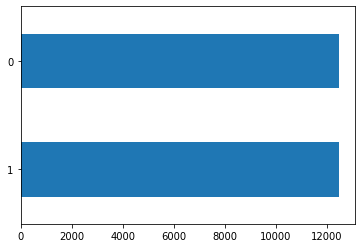

In [ ]:
import matplotlib.pyplot as plt 

df['sentiment'].value_counts().plot.barh()
plt.show()

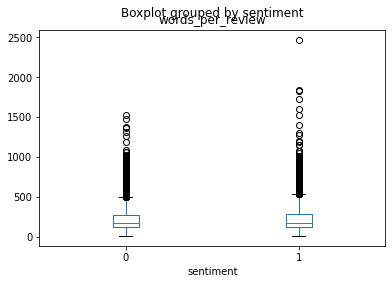

In [ ]:
df["words_per_review"] = df["review"].str.split().apply(len)
df.boxplot("words_per_review", by = 'sentiment',grid = False)
plt.show()

In [ ]:
from transformers import DistilBertTokenizer, DistilBertModel
class TrainSetBuilder():

  def __init__(self) -> None:
     # Hyper parameters
      self.max_len = 500      # Maximum number of words in a sequence
      self.train_split = 0.8  # Propotion of the dataset for training set
      self.batch_size = 10    # Number of elements in a batch

      # Training dataset
      self.train_dataset = None
      # Testing dataset
      self.test_dataset = None
      # Classes
      self.class_labels = ['Negative', 'Positive']

      # Data handlers
      self.train_handler = None
      self.test_handler = None
      self.df = None

      # Load the tokenizer
      self.tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

  def import_movie_review(self, path='/content/drive/MyDrive/movie_review_train.tsv',
                             reduce=None):
        
        self.df = pd.read_csv(path, sep='\t')
        # Import data
        
        # Concat data
        reviews = np.array(df['review'])
        sentiments = np.array(df['sentiment'])
        
        # To list
        reviews = reviews.tolist()

        # If reduce (doesn't load all the dataset
        if reduce is not None:
            print('WARNING: reduced dataset: for deboging purposes only')
            reviews = reviews[0:reduce]
            sentiments = sentiments[0:reduce]

        # Encode the batch of data
        print('Data tokenization...')
        encoded_batch = self.tokenizer.batch_encode_plus(reviews,
                                                         add_special_tokens=True,
                                                         max_length=self.max_len,
                                                         padding=True,
                                                         truncation=True,
                                                         return_attention_mask=True,
                                                         return_tensors='pt')
        print('... Done')
        # Get the spliting index
        split_border = int(len(sentiments)*self.train_split)
        # Get a tensor for sentiments
        sentiments = torch.tensor(sentiments)
        # Now encode datasets tensors
        print('Tensors encoding...')
        self.train_dataset = TensorDataset(
            encoded_batch['input_ids'][:split_border],
            encoded_batch['attention_mask'][:split_border],
            sentiments[:split_border])
        self.test_dataset = TensorDataset(
            encoded_batch['input_ids'][split_border:],
            encoded_batch['attention_mask'][split_border:],
            sentiments[split_border:])
        print('... Done')

        # Get data handler
        print('Data handler encoding...')
        self.train_handler = DataLoader(
            self.train_dataset,
            sampler=RandomSampler(self.train_dataset),
            batch_size=self.batch_size)

        self.test_handler = DataLoader(
            self.test_dataset,
            sampler=SequentialSampler(self.test_dataset),
            batch_size=self.batch_size)
        print('... Done')
        print('End of dataset encoding.')


In [ ]:
# Get the dataset instance
dataset = TrainSetBuilder()
# Import allo_cine data
dataset.import_movie_review(reduce=None)

Data tokenization...
... Done
Tensors encoding...
... Done
Data handler encoding...
... Done
End of dataset encoding.


In [16]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
import pickle
import os
import matplotlib.pyplot as plt
from math import *
from tqdm import tqdm

class distilBERT():

    def __init__(self, name='Final_Work',
                 colab=False,  # If we are using google colab
                 reset_if_exist=False,  # If we want to delete an existing model to train a new
                 force_cpu=False,  # Force cpu using while cuda is present
                 externe=False,
                 ):

        # Hyper parameters
        self.learning_rate = 5e-7  # Learning rate for Adam optimizer
        self.epslilon = 1e-8  # Epsilon limit for optimizer
        self.pred_batch_size = 1000  # Batch size for predictions

        # Download pre-trained camembert
        self.model = DistilBertForSequenceClassification.from_pretrained(
            'distilbert-base-uncased',
            num_labels=2  # Binary classification
        )
        # Classes labels
        self.class_labels = ['Negative', 'Positive']

        # The optimizer to use
        self.optimizer = AdamW(self.model.parameters(),
                               lr=self.learning_rate,
                               eps=self.epslilon)

        # Get the tokenizer from BERT pre-trained
        self.tokenizer =  DistilBertTokenizer.from_pretrained(
            'distilbert-base-uncased'
           
        )
        # A softmax function for predictions
        self.soft_pred = torch.nn.Softmax(dim=1)

        # Device:
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

        # The actual epoch idx and total tracking index
        self.epoch_idx = 0
        self.total_idx = 0

        # Some paths and name:
        self.name = name
        tmp = ''
        
        tmp = '/content/drive/MyDrive/cluepoints/'
        
        self.model_path = '{}Model/{}/Weights'.format(tmp, name)
        self.optimizer_path = '{}Model/{}/Optimizer'.format(tmp, name)
        self.tracking_path = '{}Model/{}/Tracking'.format(tmp, name)

        # # Load model if exist
        # gen_idx = 0
        # mod_lst = os.listdir(self.model_path)
        # if len(mod_lst) > 0:
        #     idx_lst = []
        #     for itm in mod_lst:
        #         idx_lst.append(int(itm.replace('.pt', '')))
        #     gen_idx = int(max(idx_lst))

        # try:
        #     self.model.load_state_dict(torch.load('{}/{}.pt'.format(self.model_path, gen_idx)))
        #     print('Existing model successfully loaded')
        #     self.optimizer.load_state_dict(torch.load('{}/{}'.format(self.optimizer_path, gen_idx)))
        #     print('Optimizer state successfully loaded')
        # except:
        #     print('WARNING: No Model to restore')
        #     pass
        # gen_idx += 1

        # # Get last epoch idx
        # try:
        #     df = pd.read_csv('{}/Total_Tracking.csv'.format(self.tracking_path), sep=';', header=None).to_numpy()
        #     self.epoch_idx = int(np.max(df[:, 0])) + 1
        # except:
        #     pass

        # self.total_idx = gen_idx


    def train(self,
              dataset,  # A TrainSetBuilder element
              nb_epoch=100  # The number of epochs to perform
              ):

        # Get data handlers
        train_dataloader = dataset.train_handler
        test_dataloader = dataset.test_handler

        # Get an iterator for the testing loader
        test_iter = iter(test_dataloader)

        # Get epochs index
        e_start = self.epoch_idx
        e_end = self.epoch_idx + nb_epoch

        # The training loop
        for epoch in range(e_start, e_end):
            tmp_train_loss = []
            # Training mode
            self.model.train()
            epoch_train_loss = []
            epoch_test_loss = []

            for step, batch in enumerate(train_dataloader):
                # Delete cache
                torch.cuda.empty_cache()
                # Set batch's data to gpu
                input_id = batch[0].to(self.device)
                attention_mask = batch[1].to(self.device)
                sentiment = batch[2].to(self.device)
                # Swipe gradients
                self.model.zero_grad()
                # Predict
                prd = self.model(input_id,
                                 
                                 attention_mask=attention_mask,
                                 labels=sentiment)
                loss = prd.loss
                logits = prd.logits
                # Backward and optimization
                loss.backward()
                self.optimizer.step()
                # Store temp loss
                tmp_train_loss.append(loss.cpu().detach().item())
                epoch_train_loss.append(loss.cpu().detach().item())

                # Tracking each 50 batchs
                if step % 50 == 0:
                    tmp_test_loss = []
                    # Compute 10 batchs on the test set
                    self.model.eval()
                    with torch.no_grad():
                        for t in range(0, 10):
                            try:
                                test_batch = next(test_iter)
                            except:
                                test_iter = iter(test_dataloader)
                                test_batch = next(test_iter)
                            # Get data
                            input_id = test_batch[0].to(self.device)
                            attention_mask = test_batch[1].to(self.device)
                            sentiment = test_batch[2].to(self.device)
                            # Predict
                            prd = self.model(input_id,
                                             attention_mask=attention_mask,
                                             labels=sentiment)
                            test_loss = prd.loss
                            tmp_test_loss.append(test_loss.cpu().detach().item())
                            epoch_test_loss.append(test_loss.cpu().detach().item())

                    # Get the mean loss
                    train_loss = np.mean(tmp_train_loss)
                    tmp_train_loss = []
                    test_loss = np.mean(tmp_test_loss)

                    print('Epoch {}, step {} - Total_idx {} - Train Loss: {} - Test Loss: {}'.format(epoch,
                                                                                        step,
                                                                                        self.total_idx,
                                                                                        train_loss,
                                                                                        test_loss))
                    # Write in file
                    tmp = [str(epoch), str(self.total_idx), str(step), str(train_loss), str(test_loss)]
                    file = open('{}/Total_Tracking.csv'.format(self.tracking_path), 'a')
                    file.write('{}\n'.format(';'.join(tmp)))
                    file.close()

                    # Save parameters
                    torch.save(self.model.state_dict(), '{}/{}.pt'.format(self.model_path, self.total_idx))
                    torch.save(self.optimizer.state_dict(), '{}/{}.pt'.format(self.optimizer_path, self.total_idx))
                    # Update general idx
                    self.total_idx += 1

                    # # Delete old models
                    # mod_lst = os.listdir(self.model_path)
                    # for itm in mod_lst:
                    #     itm_idx = int(itm.replace('.pt', ''))
                    #     if itm_idx < self.total_idx and self.total_idx - itm_idx > 5:
                    #         if itm_idx % 5 != 0:
                    #             try:
                    #                 os.remove('{}/{}.pt'.format(self.model_path, itm_idx))
                    #                 os.remove('{}/{}.pt'.format(self.optimizer_path, itm_idx))
                    #             except:
                    #                 print('Error during old model deleting')

            # Epoch loss computing
            ep_train_loss = np.mean(epoch_train_loss)
            ep_test_loss = np.mean(epoch_test_loss)

            file = open('{}/Epoch_Tracking.csv'.format(self.tracking_path), 'a')
            file.write('{};{};{}\n'.format(epoch, ep_train_loss, ep_test_loss))
            file.close()
            print('\t* ===================================== *')
            print('\t* Epoch {} :'.format(epoch))
            print('\t* \t Average Train Loss: {}'.format(ep_train_loss))
            print('\t* \t Average Test Loss: {}'.format(ep_test_loss))




    

In [17]:
model = distilBERT()
model.train(dataset, nb_epoch=100)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classi

Epoch 0, step 0 - Total_idx 0 - Train Loss: 0.7170134782791138 - Test Loss: 0.6983825206756592
Epoch 0, step 50 - Total_idx 1 - Train Loss: 0.6932957899570465 - Test Loss: 0.6934653162956238
Epoch 0, step 100 - Total_idx 2 - Train Loss: 0.6941992402076721 - Test Loss: 0.6909090340137481
Epoch 0, step 150 - Total_idx 3 - Train Loss: 0.6900856018066406 - Test Loss: 0.6850231170654297
Epoch 0, step 200 - Total_idx 4 - Train Loss: 0.6899113142490387 - Test Loss: 0.6836056053638458
Epoch 0, step 250 - Total_idx 5 - Train Loss: 0.6855999827384949 - Test Loss: 0.6822867870330811
Epoch 0, step 300 - Total_idx 6 - Train Loss: 0.6821113753318787 - Test Loss: 0.6828506588935852
Epoch 0, step 350 - Total_idx 7 - Train Loss: 0.6799024450778961 - Test Loss: 0.6769521653652191
Epoch 0, step 400 - Total_idx 8 - Train Loss: 0.6737342774868011 - Test Loss: 0.6708295106887817
Epoch 0, step 450 - Total_idx 9 - Train Loss: 0.6655327010154725 - Test Loss: 0.6598804116249084
Epoch 0, step 500 - Total_idx 10 

KeyboardInterrupt: ignored

For assessment tools, we can discuss them directly. 
Julien 